# 🧠 Aide pour le Challenge CTF - Data Leakage
Dans ce challenge, tu vas entraîner un modèle de machine learning sur un jeu de données de startups.
Le but est de prédire si une startup va réussir (`Success = 1`) ou échouer (`Success = 0`)


## 🕵️ Étapes conseillées

**Explorer les données** : affiche quelques lignes


**Vérifier la corrélation** entre les colonnes


Est-ce qu’une information est trop prédictive, comme un identifiant ou un code qui encode le succès ?

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('D:\Documents 2\VScode projects\ROBAI2\challenges\data\startup.csv')

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Founding Year             200 non-null    int64  
 1   Team Size                 200 non-null    int64  
 2   Funding Amount (USD)      200 non-null    float64
 3   Number of AI Patents      200 non-null    int64  
 4   Website Visits per Month  200 non-null    int64  
 5   CEO Name                  200 non-null    object 
 6   Startup Code              200 non-null    object 
 7   Success                   200 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 12.6+ KB
None
       Founding Year   Team Size  Funding Amount (USD)  Number of AI Patents  \
count     200.000000  200.000000          2.000000e+02              200.0000   
mean     2016.930000   50.135000          4.992184e+06                3.0400   
std         4.003152   29.210839      

Missing values:
 Founding Year               0
Team Size                   0
Funding Amount (USD)        0
Number of AI Patents        0
Website Visits per Month    0
CEO Name                    0
Startup Code                0
Success                     0
dtype: int64
0       S-FAIL-2824
1       S-FAIL-1409
2    S-SUCCESS-5506
3       S-FAIL-5012
4    S-SUCCESS-4657
5    S-SUCCESS-3286
6       S-FAIL-2679
7       S-FAIL-9935
8    S-SUCCESS-2424
9    S-SUCCESS-7912
Name: Startup Code, dtype: object


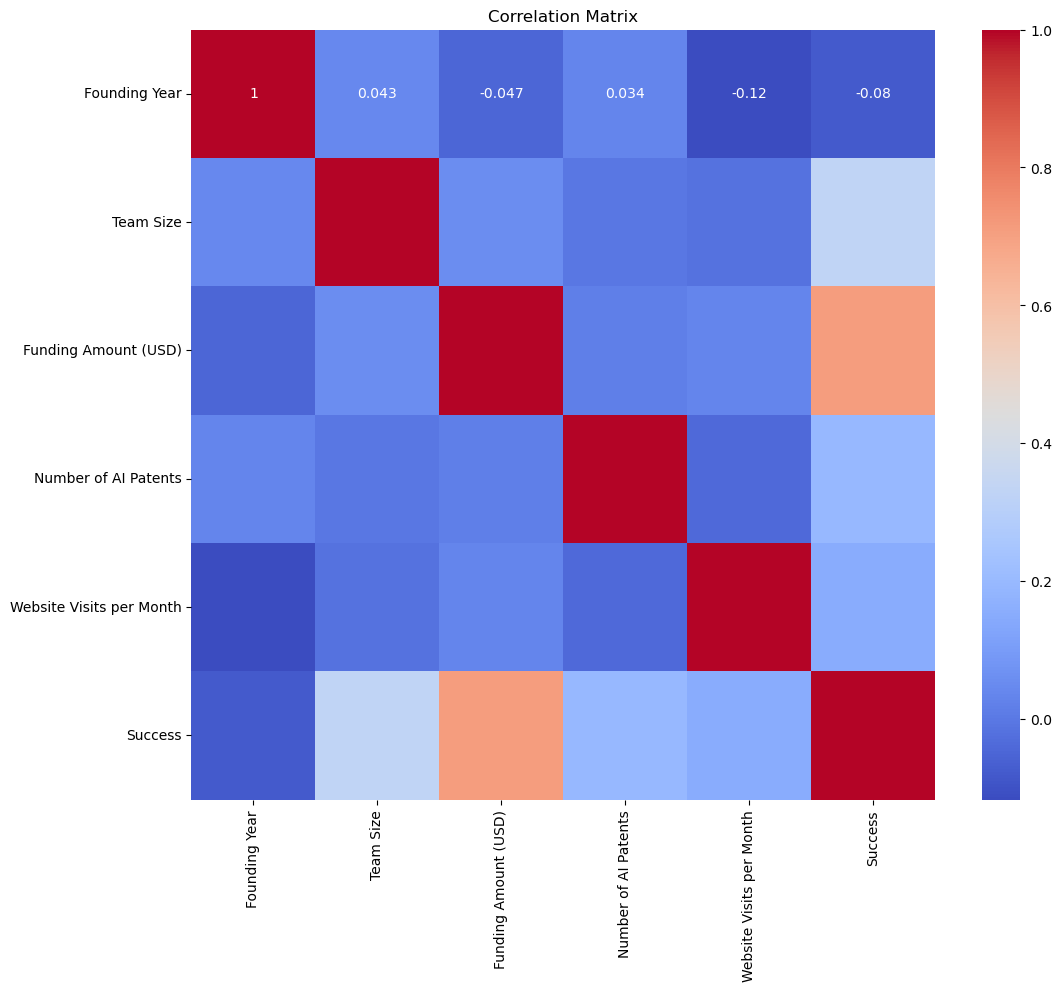

In [11]:
print("Missing values:\n", df.isnull().sum())

# Examine the Startup Code column
print(df['Startup Code'].head(10))

# Check correlation between columns
plt.figure(figsize=(12, 10))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

In [12]:
# Check the relationship between CEO names and success
ceo_success_rate = df.groupby('CEO Name')['Success'].mean().sort_values(ascending=False)
print("CEO Success Rate:\n", ceo_success_rate)

# Remove biasing columns - Startup Code definitely needs to be removed
df_cleaned = df.drop('Startup Code', axis=1)

# Convert CEO Name to dummy variables
df_cleaned = pd.get_dummies(df_cleaned, columns=['CEO Name'], drop_first=True)

CEO Success Rate:
 CEO Name
Alice      1.0
Bob        1.0
Charlie    1.0
Dana       1.0
Eve        0.0
Frank      0.0
Grace      0.0
Heidi      0.0
Name: Success, dtype: float64


In [13]:
# Split features and target
X = df_cleaned.drop('Success', axis=1)
y = df_cleaned['Success']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

In [14]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Check feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("\nFeature Importances:")
print(feature_importances.sort_values(ascending=False))

# Visualize feature importances
plt.figure(figsize=(12, 8))
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.savefig('feature_importances.png')
plt.close()

Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        23

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Feature Importances:
Funding Amount (USD)        0.387402
Team Size                   0.096636
CEO Name_Eve                0.083525
CEO Name_Grace              0.083179
CEO Name_Charlie            0.065767
CEO Name_Frank              0.053601
Website Visits per Month    0.052241
CEO Name_Heidi              0.045766
CEO Name_Bob                0.043855
CEO Name_Dana               0.038118
Number of AI Patents        0.027570
Founding Year               0.022339
dtype: float64


## 🧩 Objectif final

Supprime les colonnes qui biaisent l’apprentissage.

Tu dois entraîner un modèle **qui généralise bien**